<h1> ME 144 - SNOW FARMING PROJECT - Javier Lobato </h1>

<h3> Preamble </h3>

In [1]:
%matplotlib inline 
# plots graphs within the notebook

from IPython.display import display,Image, Latex
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
from IPython.display import clear_output

import time

from IPython.display import display,Image, Latex

from IPython.display import clear_output


import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc
import scipy.optimize

import SchemDraw as schem
import SchemDraw.elements as e

import sympy as sym
from scipy import optimize

from NewLibraries import thermodynamics as thermo
    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)

class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
from scipy.constants import convert_temperature
def C2K(T):
    return convert_temperature(T,'Celsius','Kelvin')
def C2F(T):
    return convert_temperature(T,'Celsius','Fahrenheit')
def F2K(T):
    return convert_temperature(T,'Fahrenheit','Kelvin')
def F2C(T):
    return convert_temperature(T,'Fahrenheit','Celsius')
def K2F(T):
    return convert_temperature(T,'Kelvin','Fahrenheit')
def K2C(T):
    return convert_temperature(T,'Kelvin','Celsius')

import pandas as pd
from pandas import Series

<h3> Problem statement </h3>

Snow farming is a relatively new approach to address the emerging uncertainties in snow coverages. Started in Scandinavia, the idea is to store snow over the summer to create a training loop when the ground freezes in the November/December timeframe. This approach is particularly attractive in Vermont which is typically subjected to the notorious January thaw. Storing snow from the previous winter can reduce the cost of making snow in November knowing that a large fraction of that snow may disappear in January. 

The main objective of the problem is to develop a model of a snow pile. The model should be general enough to adjust the geometry of the basin holding the pile. The pile geometry should be realistic. Identify the main uncertainties in the model and perform a sensitivity analysis of your model.

In [2]:
PDF("images/pile.pdf",size=(400,280))

<h2> Assumptions: </h2>
<ul>
    <li> Length ($L$) and width ($w$) of the base will be held constant for the analysis </li>
    <li> The area of the truncated pyramid in the image above is $V=\dfrac{1}{6}h\left[ Lw+4 \left( L-\dfrac{h}{\tan\alpha} \right) \left( w-\dfrac{h}{\tan\beta} \right) + \left( L-2\dfrac{h}{\tan \alpha}\right) \left( w-\dfrac{h}{\tan\beta} \right) \right]$ as stated in this [webpage](https://www.aqua-calc.com/calculate/volume-truncated-pyramid)</li>
    <li> Given that $L$ and $w$ are fixed and the volume of the pile is fixed ($10000 m^3$), the only variables to be varied are $\alpha$ and $\beta$, given that the height $h$ is obtained from the equation above with a numerical solver. </li>
    <li> 1 dimensional heat transfer: including conduction, convection and radiation </li>
    <li> The surfaces of the snowpile are assumed to be at a constant temperature (called $T_{fixed}$) </li>
    <li> $k_{mulch}$ value has been taken from this [webpage](https://www.engineeringtoolbox.com/thermal-conductivity-d_429.html) </li>
    <li> $k_{tarp}$ was taken from this [webpage](http://www.puiaudio.com/pdf/AR027150MR-R.pdf) assuming it is a Mylar tarp</li>
    <li> The order of mulch and tarp only matters for practical purposes (such as rain) because for this heat transfer problem, the solution will be the same
</ul>
 
The snowpile will be covered with a mulch and then with tarp that will protect the snowpile from the rain. Thus, there will not be any loss of snow due to rain or ablation. 
    


<h2> Solar Radiation </h2>

The sun creates solar energy that reaches us in the form of electromagnetic waves after experiencing considerable interactions with the atmosphere. The radiation energy emitted or reflected by the molecular composition of the atmosphere is the atmospheric radiation. The net flux on the surface of the earth is the sum of the solar and atmospheric radiation. The solar radiation consists of the direct solar radiation $G_D$ and the diffuse solar radiation $G_d$. The former is the amount of the total solar energy reaching the earth's atmosphere or total solar irradiance $Gs=1.3\mathrm{kW/m}^2$ that is not absorbed or scattered by molecules of our atmospherses (gas, vapor, pollution). The direct solar radiation measured on the earth's surface is only a fraction of  $Gs$ depending on the latitude and longitude. Typically about $950\mathrm{W/m}^2$ is lost in the atmosphere on a clear day and much more on a cloudy day. The direct radiation reaches the ground at an angle $\theta$, the angle that the sun's ray make with the normal to the surface. The diffuse solar radiation is a fraction of the solar energy scattered that manages to reach the earth's surface. The total solar energy on a horizontal surface on the ground is

$$
G_{solar}=G_D\cos\theta+G_d
$$
Fortunately, this NASA website https://eosweb.larc.nasa.gov/cgi-bin/sse/global.cgi provides the monthly averaged values for the global solar irradiation $G_{solar}$. The energy absorbed by a surface depends on the solar absorptivity $\alpha_s$ of the material. The atmosphere is treated as a blackbody at some lower fictitious temperature $T_{sky}$ that emits an equivalent amount of radiation energy. The radiation from the atmosphere to the earth's surface is then expressed as 

$$
G_{sky}=\sigma T^4_{sky}
$$ 
The value of $T_{sky}$ depends on the atmospheric conditions. It ranges from  230K
for cold, clear-sky conditions to about 285K for warm, cloudy-sky conditions. For the atmopsheric radiation, we will admit (without further derivation) the absorptivity of a surface to be equal to its emissivity $\alpha=\varepsilon$. The total radiation flux from atmospheric radiation becomes:

$$
E_{sky}=E_{sky,absorbed}−E_{sky,emitted}=\varepsilon\sigma(T^4_{sky}−T^4_s)
$$
 
where $T_s$ is the surface temperature. The net rate of radiation heat transfer to a surface exposed to solar and atmospheric radiation is derived from comservation of energy:

$$
q''_{rad}=\alpha_sG_{solar}+\varepsilon\sigma(T4sky−T4s)
$$
 
It is obvious that the thermal resistance for radiation is no longer sufficient. You will have to descrive the problem in terms of conservation of thermal energy based on your thermal circuit. Note that the radiation heat transfer, like the convection heat transfer, is a function of the surface temperature of the sawdust.

In [3]:
data = np.genfromtxt('NOAA/global_radiation.txt', delimiter='', skip_header = 14, unpack=True, dtype=float)

mask = np.where(np.logical_and(data[0,:] == 44, data[1,:] == -73))
Solar_radiation = np.zeros(12)
for i in range(2,10):
    Solar_radiation[i] = data[i+2,mask]
Solar_radiation = Solar_radiation[Solar_radiation != 0.]*3600/1000

<h2> Weather data </h2>
The atmospheric data was obtained from Morrisville which is a village 17 miles away from Craftsbury. It is stored in [this webpage](https://www.wunderground.com/history/airport/KMVL/2017/3/1/CustomHistory.html?dayend=1&monthend=12&yearend=2017&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=), with the interval of interest from March to November. 

In [4]:
# Get the values and remove the non valids
dailyWd = np.genfromtxt('weatherData.txt')
dailyWd[np.isnan(dailyWd)] = 0

# Preallocation
wD = np.zeros((int(len(dailyWd)/30.),dailyWd.shape[1]))

# Get the monthly mean
for i in range(len(wD)):
    wD[i,:] = np.mean(dailyWd[30*i:30*(i+1),:], axis=0)
    
# Temperatures to Kelvin 
wD[:,1:7] = F2K(wD[:,1:7])
# Pressure from inHg to Pa
wD[:,10:13] = wD[:,10:13]/29.92*100000
# Windspeeds from mph to ms
wD[:,16:19] = wD[:,16:19]/3600*1609
# Precipitations from inches to m
wD[:,19] = wD[:,19]*0.0254

<h2> Cloud data</h2>

The sun creates solar energy that reaches us in the form of electromagnetic waves after experiencing considerable interactions with the atmosphere. The radiat

In [5]:
clouds = 1-np.array([0.51, 0.49, 0.56, 0.59, 0.64, 0.60, 0.54, 0.47, 0.31])

T_sky = np.zeros(8)
e_cloud = np.zeros(8)

for i in range (8):
    e_cloud[i] = (1-.84*clouds[i])*(0.527 + 0.161*np.exp(8.45*(1-(273/(wD[i,2]))))) + 0.84*clouds[i]
    T_sky[i] = ((9.365574e-6)*(1-clouds[i])*(wD[i,2])**6 + e_cloud[i]*clouds[i]*(wD[i,2])**4)**.25

<h2> Soil temperature </h2>
The temperature of the soil is not representative because given that the surface of the ground has been assumed to be constant, the heat transfer will be always the same.

In [6]:
Pond_543 = pd.read_csv("data/SN 20146543 2018-02-17 15_34_02 -0500.csv",
                      squeeze=True,
                      parse_dates=[0],
                      index_col=[0],
                      header = 1,
                      names = ["p50cm", "p1m"])
Pond_544 = pd.read_csv("data/SN 20146544 2018-02-17 15_33_21 -0500.csv",
                      squeeze=True,
                      parse_dates=[0],
                      index_col=[0],
                      header = 1,
                      names = ["p5cm", "p20cm"])

<h2> Truncated pyramid </h2> 
The volume of the truncated pyramid has been computed with the equation above. Both the volume equation and the equation rearranged to have a volume of 10000 and solve for the height are implemented. The sum of all lateral areas are also computed

In [7]:
def volumeCalculator(L,w,alpha,beta,h):
    a = L 
    b = w
    c = a - 2 * (h/np.tan(alpha))
    d = b - 2 * (h/np.tan(beta))
    return 1/6*h*(a*b+(a+c)*(b+d)+c*d)

In [8]:
def heightFunction(x,*param):
    L,w,alpha,beta = param
    a = L 
    b = w
    c = a - 2 * (x/np.tan(alpha))
    d = b - 2 * (x/np.tan(beta))
    return 1/6*x*(a*b+(a+c)*(b+d)+c*d)-10000

In [9]:
def airArea(L,w,alpha,beta,h):
    return 2*h*(L+w-h*(1/np.tan(alpha)+1/np.tan(beta)))+(L-2*h/(np.tan(alpha)))*(w-2*h/(np.tan(beta)))

<h2> Heat transfer diagram </h2>

This heat transfer problem is to be solved with the next thermal resistance circuit, where the two $T_{fixed}$ represent the limits of the snowpile.

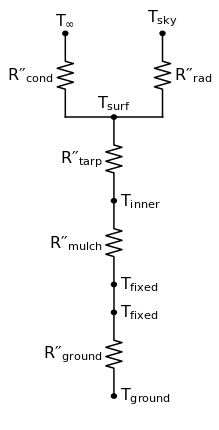

In [10]:
d = schem.Drawing()
d.add(e.DOT, toplabel = r"$T_\infty$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{cond}$")
d.add(e.LINE, d= 'right', l = 1.5)
d.push()
d.add(e.LINE, d= 'right', l = 1.5)
d.add(e.RES, d = 'up', botlabel = "$R\prime\prime_{rad}$")
d.add(e.DOT, toplabel = r"$T_{sky}$")
d.pop()
d.add(e.DOT, toplabel = r"$T_{surf}$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{tarp}$")
d.add(e.DOT, rgtlabel = r"$T_{inner}$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{mulch}$")
d.add(e.DOT, rgtlabel = r"$T_{fixed}$")
d.add(e.LINE, d= 'down', l = 1)
d.add(e.DOT, rgtlabel = r"$T_{fixed}$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{ground}$")
d.add(e.DOT, rgtlabel = r"$T_{ground}$")
d.draw()

In [11]:
# Variable declaration
T_fixed = -10. # C
epsilon = 0.9 #
alpha = 0.59 #

# Base values
L = 65
W = 70

t_mul = 0.01 # Moltch thickness
t_tarp = 0.05 # tarp thickness
k_mul = 0.08 # W/(mK) for sawdust 
k_tarp = 0.15 # W/(mK) for Mylar  

R_tarp = t_tarp/k_tarp # Resistance of the tarp

In [12]:
# The next equation is the conservation of energy equation in the T_surf, including radiation and convection
# This is to be solved with fsolve and obtain the T_surf
def f(x, *data):
    R_cond, Sol_rad, Tsky, h, Tinft = data
    return -(x-C2K(T_fixed))/R_cond+alpha*Sol_rad+epsilon*sc.sigma*(Tsky**4-x**4)+h*(Tinft-x)

In [13]:
def heatCalculator(thickness):
    # This will loop over the 8 months
    q_cond = np.zeros(8)
    R_mul = thickness/k_mul
    R_cond = R_mul + R_tarp
    for i in range(8):
        T_guess = (C2K(T_fixed) + T_sky[i])/2.        
        T_s = scipy.optimize.fsolve(f, T_guess, args=(R_cond, Solar_radiation[i], T_sky[i], h[i], wD[i,2]))
        q_cond[i] = (T_s-C2K(T_fixed))/R_cond
        # This was used to find out if the calculations were done right
#         q_conv = h[iterat]*(wD[iterat,2]-T_s)
#         q_rad = alpha*Solar_radiation[iterat]+epsilon*sc.sigma*(T_sky[iterat]**4-T_s**4)
    return np.sum(q_cond)


In order to solve the equation, it is needed the convective coefficient from the air. Assuming that each wall of the pile may be considered as a flat plate and computing the density for each one of the months:

In [14]:
# Compute the density of air 
density = wD[:,11]/(wD[:,2]*287)
air  = thermo.Fluid('air')
Re = np.zeros((len(wD[:,2])))

# Taking an average of the distances
dist = (L+W)/2

for i in range(len(wD[:,2])):
    air.get_properties(wD[i,2])
    Re[i] = density[i]*wD[i,17]*dist/air.mu
# Remove some possible Reynolds were the velocity of the wind is zero (used for daily calculations)
Re = Re[Re != 0]

h = np.zeros(len(Re))
for i in range(len(Re)):
    air.get_properties(wD[i,2])
    Nu = 0.0296*np.power(Re[i],4./5.)*np.power((air.nu/air.alpha),1./3.)
    h[i] = Nu*air.k/dist

<h2> Parameter sweep </h2>
In order to draw soe conclusions, a sweep of the different variables (alpha, beta and mulch thickness) will be made. 

In [15]:
N = 11

thickness = np.linspace(0.01,0.1,N)
alphaArray = np.deg2rad(np.linspace(20,40,N))
betaArray = np.deg2rad(np.linspace(20,40,N))

In [16]:
# Compute teh sum of the heat transfer 
Q_surf = np.zeros(N)
for i in range(N):
    Q_surf[i] = heatCalculator(thickness[i])

In [17]:
# The height will depend on the chosen values of alpha and beta
height = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        height[i,j] = scipy.optimize.fsolve(heightFunction,10,args=(L,W,alphaArray[i],betaArray[j]))

In [18]:
# Total heat transfer is computed for the lateral areas times heat per unit area
area = airArea(L,W,alphaArray,betaArray,height)
totalQ = np.zeros((N,N,N))
for i in range(N):
    totalQ[:,:,i] = area*Q_surf[i]

In [19]:
Ab, aB = np.meshgrid(alphaArray, betaArray)
At, aT = np.meshgrid(alphaArray, thickness)
Tb, tB = np.meshgrid(thickness, betaArray)


In [20]:
levels = 50

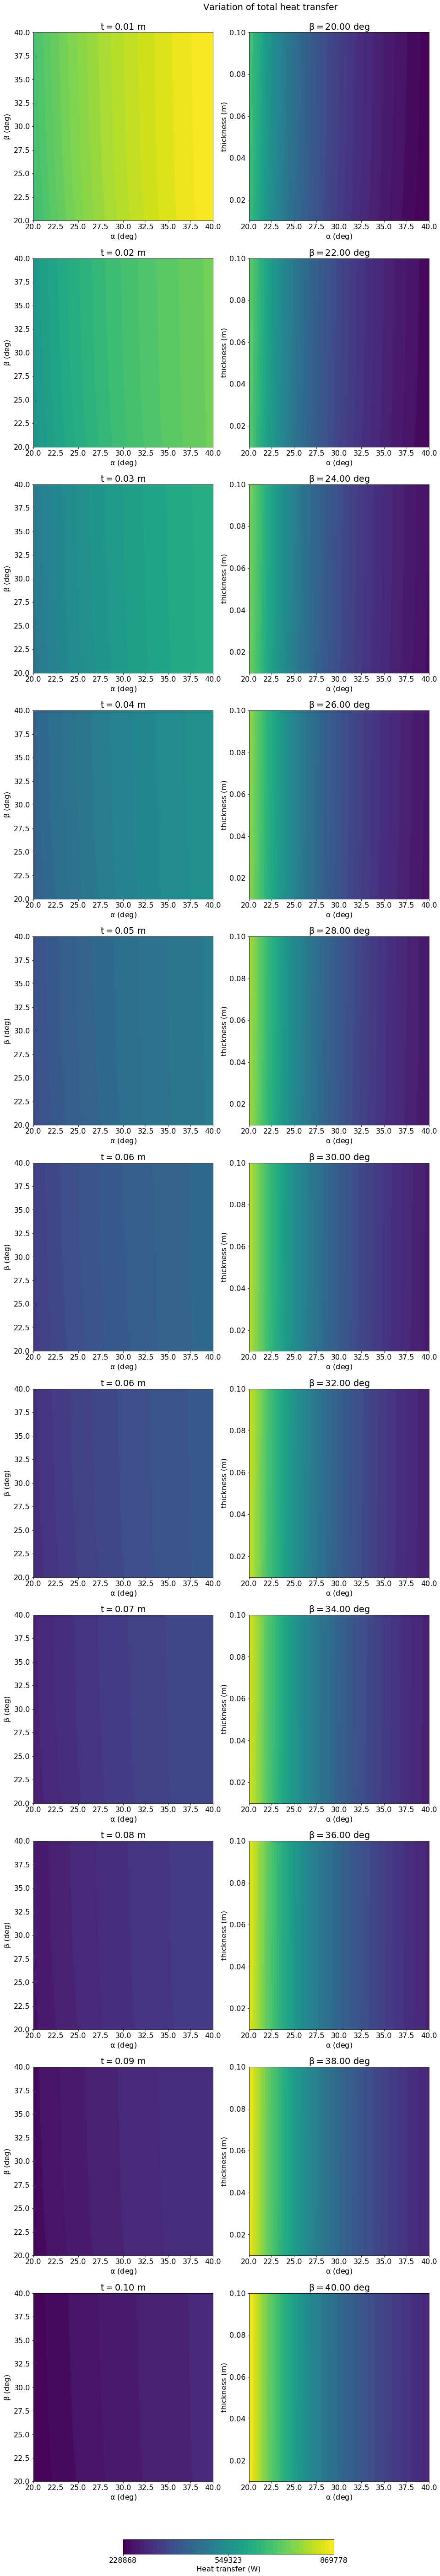

In [21]:
fig, ax = plt.subplots(N,2,figsize=(16,8*N))
for i in range(N):
    if i == N-1:
        cntfL = ax[i][0].contourf(np.rad2deg(Ab),np.rad2deg(aB),totalQ[:,:,i],np.linspace(np.min(totalQ), np.max(totalQ), levels))
    else:
        ax[i][0].contourf(np.rad2deg(Ab),np.rad2deg(aB),totalQ[:,:,i],np.linspace(np.min(totalQ), np.max(totalQ), levels))
    ax[i][0].set_xlabel(r'$\alpha$ (deg)')
    ax[i][0].set_ylabel(r'$\beta$ (deg)')
    ax[i][0].set_title(r'$t = %.2f $ m' %thickness[i])

for i in range(N):
    if i == N-1:
        cntfR = ax[i][1].contourf(np.rad2deg(At),aT,totalQ[:,i,:],np.linspace(np.min(totalQ), np.max(totalQ), levels))
    else:
        ax[i][1].contourf(np.rad2deg(At),aT,totalQ[:,i,:],np.linspace(np.min(totalQ), np.max(totalQ), levels))
    ax[i][1].set_xlabel(r'$\alpha$ (deg)')
    ax[i][1].set_ylabel(r'thickness (m)')
    ax[i][1].set_title(r'$\beta = %.2f $ deg' %np.rad2deg(betaArray[i]))
    
fig.suptitle('Variation of total heat transfer')
fig.subplots_adjust(top=0.97)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.22, 0.1, 0.4, 0.005])
cbar = fig.colorbar(cntfR, orientation="horizontal", cax=cbar_ax)
cbar.set_label('Heat transfer (W)')
cbar.set_ticks([np.min(totalQ),np.mean((np.min(totalQ),np.max(totalQ))), np.max(totalQ)])

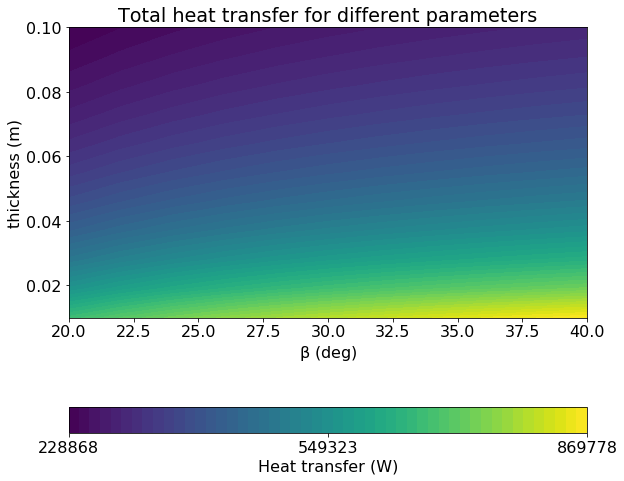

In [22]:
fig, ax = plt.subplots(1,figsize=(8,8))
cntf = ax.contourf(np.rad2deg(tB),Tb,totalQ[0,:,:],np.linspace(np.min(totalQ), np.max(totalQ), levels))
ax.set_xlabel(r'$\beta$ (deg)')
ax.set_ylabel(r'thickness (m)')
ax.set_title(r'Total heat transfer for different parameters')
cbar = fig.colorbar(cntf, orientation="horizontal", pad=0.2)
cbar.set_label('Heat transfer (W)')
cbar.set_ticks([np.min(totalQ),np.mean((np.min(totalQ),np.max(totalQ))), np.max(totalQ)])

It can be seen that, as expected, the higher the thickness of the mulch layer, the lower the value of the heat transfer, because the thermal resistance is higher. When talking about angles, the best configuration is achieved with the specified $L=65\ m$, $w=70\ m$, $\alpha=24\ deg$, $\beta=30\ deg$ and the correspondant $h=2.57\ m$. If the volume of the snowpile is computed it is:

In [23]:
volumeCalculator(65,70,np.deg2rad(24),np.deg2rad(30),2.57)

9999.506374760636

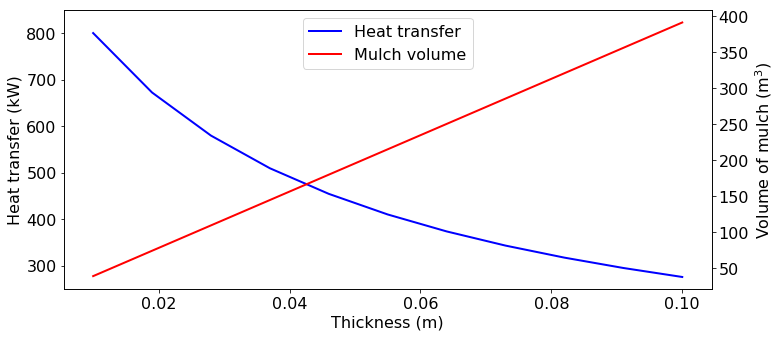

In [24]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(thickness, totalQ[2,5,:]/1000,'b-',linewidth=2,label='Heat transfer')
ax.plot([0.04,0.07], [60,50],'r-',linewidth=2,label='Mulch volume')
ax.set_ylim([250,850])
ax.set_xlabel('Thickness (m)')
ax.set_ylabel('Heat transfer (kW)')
ax1 = ax.twinx()
ax1.plot(thickness, airArea(65,70,np.deg2rad(24),np.deg2rad(30),2.57)*thickness,'r-',linewidth=2)
ax1.set_ylabel(r'Volume of mulch ($m^3$)')
ax.legend(loc='upper center')

When choosing a thickness of the mulch, and given that higher thickness will always give smaller heat transfers, the volume of the mulch must be considered. The mulch will also have problems to stay in the slope of the snowpile, because it will try to go downwards, so the thinner the layer, the better.

<h2> Future developments </h2>
As future developments of the model, a more accurate analysis should be performed. In order to get more interesting results, some optimization algorithm may be used in order to known which is the correct shape of the snow pile. A genetic algorithm must be considered as a good way of approaching the problem, and just out of curiosity, over the summer this implementation will be done. Other improvements may be:
<ul>
    <li> Including more realistic data, without doing mean nor average per day, should also improve the accuracy of the results </li>
    <li> The daily values of temperature may be used to avoid computing means of months to estimate different values </li>
    <li> The area may get under shadows, having different areas of sun and shadows </li>
    <li> Different values depending on humidity may be assumed </li>
    <li> Estimate the daily hours of light using online resources </li>
</ul>
